In [128]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.student import StudentFullCov
from mcjax.proba.student import StudentDiag





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# initialize jax RNG
key = jr.PRNGKey(0)

### General Multivariate Student-t Distribution

In [135]:
dim = 2
deg = 5
M = np.random.normal(0,1, (dim, dim))
mu = np.random.normal(0,1, dim)
cov = M @ M.T

# full cov
dist = StudentFullCov.create(dim=2)
params = dist.init_params(mu=mu, cov=cov, df=deg)

# diagonal cov
# dist = StudentDiag.create(dim=2)
# params = dist.init_params(mu=mu, log_std=np.log(np.diag(cov)), df=deg)


log_density = lambda x: dist.log_prob(params, x)
log_density_batch = jax.vmap(log_density)


In [136]:
params

StudentFullCovParams(mu=array([-0.52598149,  0.96291937]), log_diag=Array([ 0.94051665, -0.65741956], dtype=float32), cov_chol_lower=Array([[0.       , 0.       ],
       [1.0894768, 0.       ]], dtype=float32), df=Array(5, dtype=int32, weak_type=True))

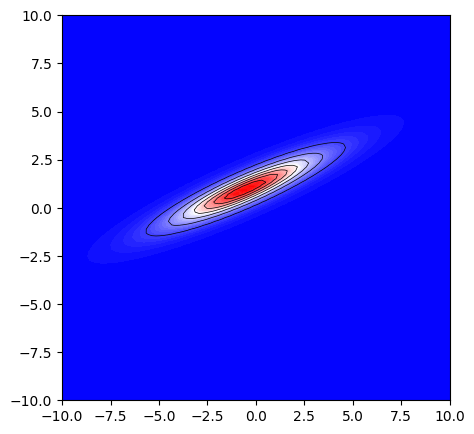

In [137]:
key, key_ = jr.split(key)
n_samples = 100_000
# samples = dist.sample(key=key_, n_samples=n_samples)
samples = dist.sample(key=key_, params=params, n_samples=n_samples)


# plot contour plot of the distribution
xmin, xmax = -10, 10
ymin, ymax = -10, 10
npts = 100
X, Y = np.meshgrid(np.linspace(xmin, xmax, npts), np.linspace(ymin, ymax, npts), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
XY = jnp.stack([X_flat, Y_flat], axis=-1)
#Z_flat = dist.batch(XY)
Z_flat = log_density_batch(XY)
Z = Z_flat.reshape(X.shape)

plt.figure(figsize=(5,5))
# plot contour plot of the distribution with levels in black
plt.contour(X, Y, jnp.exp(Z), levels=10, colors='k', linewidths=0.5)
plt.contourf(X, Y, jnp.exp(Z), levels=50, cmap='bwr')




Empirical mean: [-0.5217406   0.96387047]
Theoretical mean: [-0.52598149  0.96291937]
Empirical cov: 
 [[11.092577   4.718331 ]
 [ 4.718331   2.4537222]]
Theoretical cov: 
 [[10.933801   4.650803 ]
 [ 4.650803   2.4257953]]


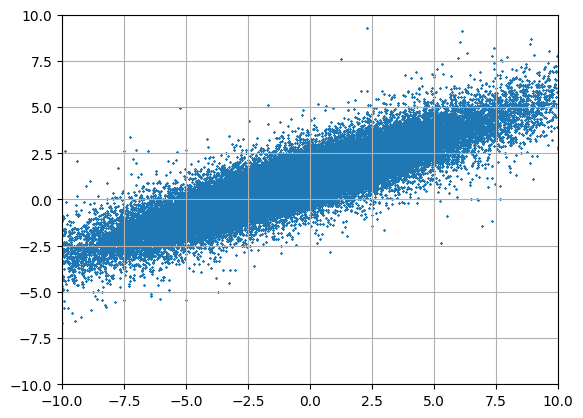

In [138]:
# plot scatter plot of samples
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.scatter(samples[:, 0], samples[:, 1], s=1, marker='x')
plt.grid()

# empirical mean and variance
mean = jnp.mean(samples, axis=0)
# covariance matrix
C = jnp.cov(samples.T)
print(f"Empirical mean: {mean}")
print(f"Theoretical mean: {mu}")
print(f"Empirical cov: \n {C}")
cov_theoretical = cov * params.df / (params.df - 2)
print(f"Theoretical cov: \n {cov_theoretical}")

In [139]:
# test this density integrates to one
n_samples = 1_000_000
key, key_ = jr.split(key)
xmin, xmax = -20, 20
samples = jr.uniform(key_, shape=(n_samples, 2), minval=xmin, maxval=xmax)

# importance sampling from the uniform to compute the integral
log_density_samples = log_density_batch(samples)

# estimate the integral
integral = jnp.mean(jnp.exp(log_density_samples)) * (xmax - xmin) ** 2
print(f"Estimated integral: {integral}")

Estimated integral: 1.0069652795791626
